In [1]:
import pandas as pd
import numpy as np

In [2]:
################################################################################################################
#                   This is to create a csv file(train.csv) by combining all the four files                    #
################################################################################################################
# # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
# train = open('train.csv', mode='a')

# row = list()
# files=['netflix/combined_data_1.txt','netflix/combined_data_2.txt', 
#        'netflix/combined_data_3.txt', 'netflix/combined_data_4.txt']
# for file in files:
#     with open(file) as f:
#         for line in f:
#             del row[:]
#             line = line.strip()
#             if line.endswith(':'):
#                 movie_id = line.replace(':', '')
#             else:
#                 row = [x for x in line.split(',')]
#                 row.insert(0, movie_id)
#                 train.write(','.join(row))
#                 train.write('\n')
# train.close()

## We are removing duplicates and store them in a new csv file

In [3]:
# prev = train_df.shape[0];

# print('With duplicates    :', prev)
# train_df.drop_duplicates(inplace=True)
# present = train_df.shape[0]
# print("Without duplicates :", present)


# there were 716 duplicate rows....
# print("\n There were",(present-prev),"duplicates")

In [4]:
# train_df.to_csv('new_train.csv', index=False)

In [5]:
train_df = pd.read_csv('new_train.csv', sep=',',
                      parse_dates=['date'], index_col='date')
train_df.head()

,movie,user,rating
date,,,
2005-09-06,1,1488844,3.0
2005-05-13,1,822109,5.0
2005-10-19,1,885013,4.0
2005-12-26,1,30878,4.0
2004-05-03,1,823519,3.0


## Is there any rating that has incorrect entry...?  

In [6]:
sum(train_df.rating > 5.0)

0

In [7]:
movies = train_df.movie.value_counts().sort_index()
users = train_df.user.value_counts().sort_index()
ratings = train_df.rating

print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(users))
print("Total No of movies  :", len(movies))


Total no of ratings : 100479540
Total No of Users   : 480189
Total No of movies  : 17770


In [8]:
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

In [9]:
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

<IPython.core.display.Javascript object>


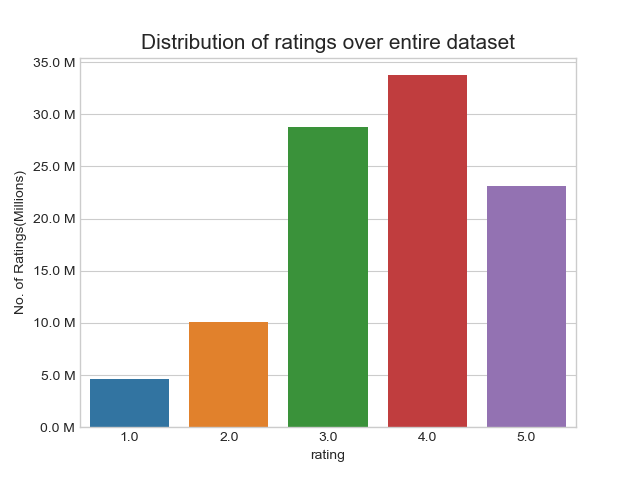

In [21]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over entire dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

### Add new columns to the data set year, month and week day for analysis.

In [11]:
train_df['year']  = train_df.index.year
train_df['month'] = train_df.index.month
train_df['day_of_week'] = train_df.index.weekday_name

In [12]:
train_df.head()

,movie,user,rating,year,month,day_of_week
date,,,,,,
2005-09-06,1,1488844,3.0,2005,9,Tuesday
2005-05-13,1,822109,5.0,2005,5,Friday
2005-10-19,1,885013,4.0,2005,10,Wednesday
2005-12-26,1,30878,4.0,2005,12,Monday
2004-05-03,1,823519,3.0,2004,5,Monday


<IPython.core.display.Javascript object>


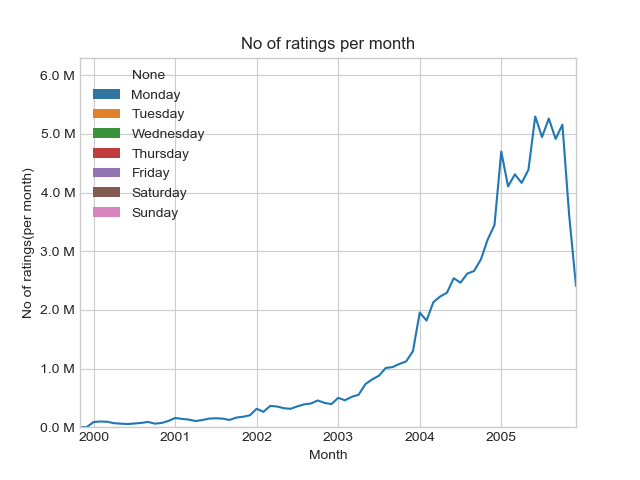

In [26]:
ax = train_df.resample('m')['rating'].count().plot()
ax.set_title('No of ratings per month')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

In [14]:
temp_df = train_df[train_df.movie==15].groupby(['rating'])['user'].count()

In [15]:
temp_df.head()

rating
1.0    30
2.0    35
3.0    88
4.0    96
5.0    41
Name: user, dtype: int64

In [16]:
temp_df.index, temp_df.values

(Float64Index([1.0, 2.0, 3.0, 4.0, 5.0], dtype='float64', name='rating'),
 array([30, 35, 88, 96, 41], dtype=int64))

<IPython.core.display.Javascript object>


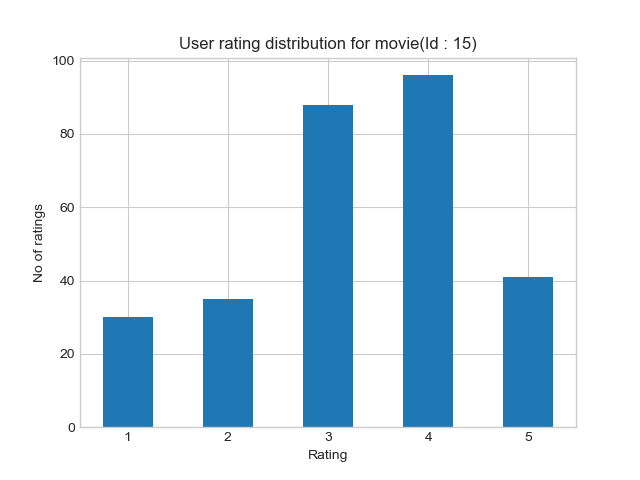

In [27]:
plt.bar(temp_df.index, temp_df.values,width=0.5)
plt.title('User rating distribution for movie(Id : 15)')
plt.xlabel('Rating')
plt.ylabel('No of ratings')
plt.show()

<IPython.core.display.Javascript object>


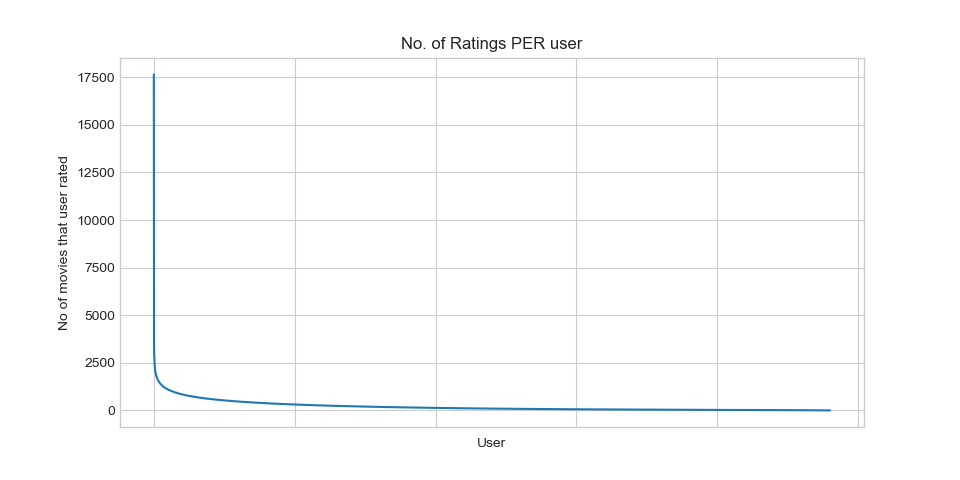

In [18]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()

plt.plot(no_of_rated_movies_per_user.values)
plt.title('No. of Ratings PER user')
plt.xlabel('User')
plt.ylabel('No of movies that user rated')
ax.set_xticklabels([])

plt.show()

<IPython.core.display.Javascript object>


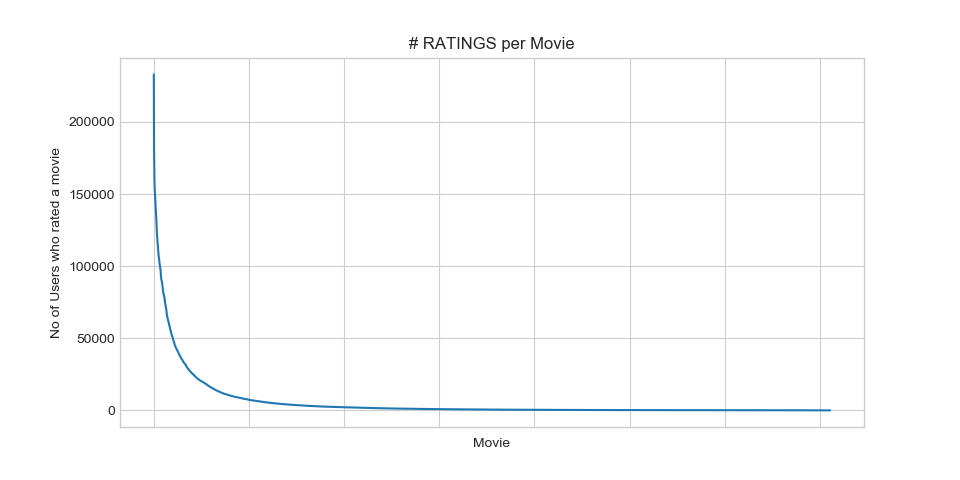

In [28]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])
plt.show()

<IPython.core.display.Javascript object>


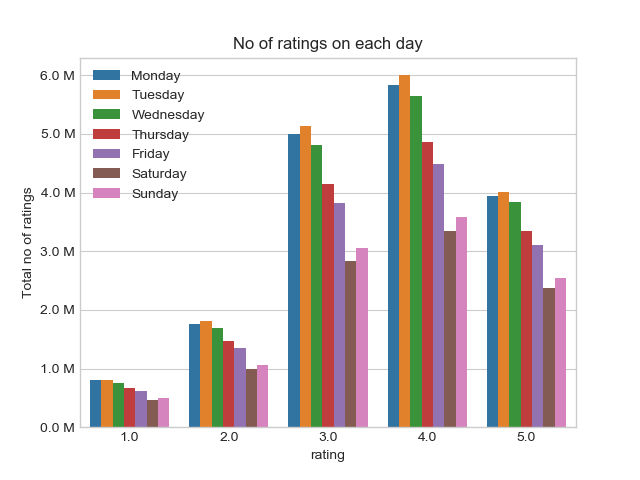

In [29]:
fig, ax = plt.subplots()

sns.countplot(x='rating', data=train_df, hue='day_of_week', 
              hue_order=['Monday','Tuesday','Wednesday','Thursday','Friday',
                         'Saturday', 'Sunday'])
plt.title('No of ratings on each day')
plt.ylabel('Total no of ratings')
plt.legend(loc='upper left')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

<IPython.core.display.Javascript object>


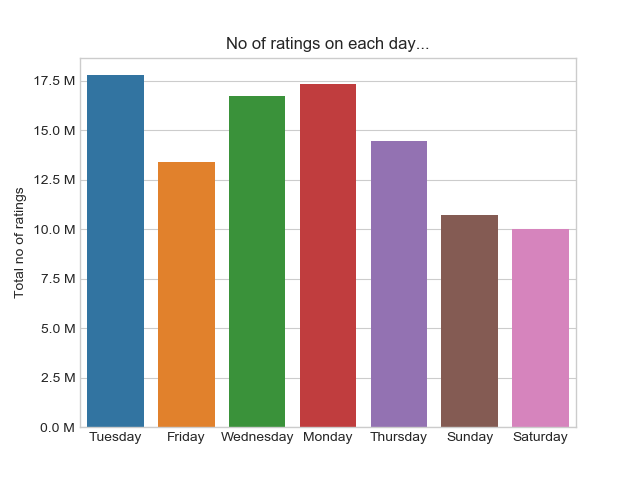

In [30]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

<IPython.core.display.Javascript object>


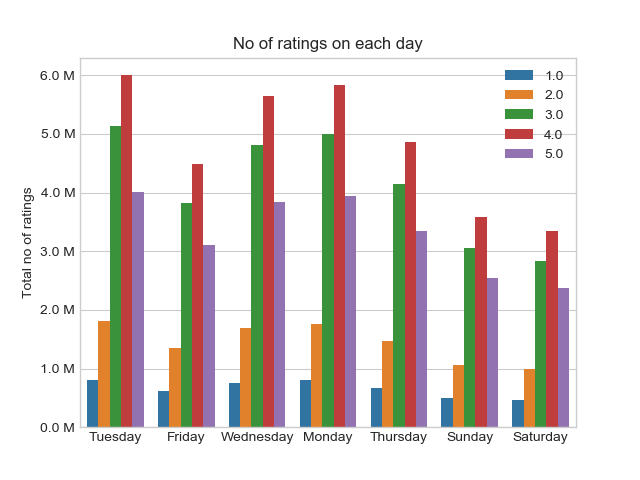

In [31]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, hue='rating', ax=ax)
plt.title('No of ratings on each day')
plt.ylabel('Total no of ratings')
plt.xlabel('')
plt.legend(loc='best')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

<IPython.core.display.Javascript object>


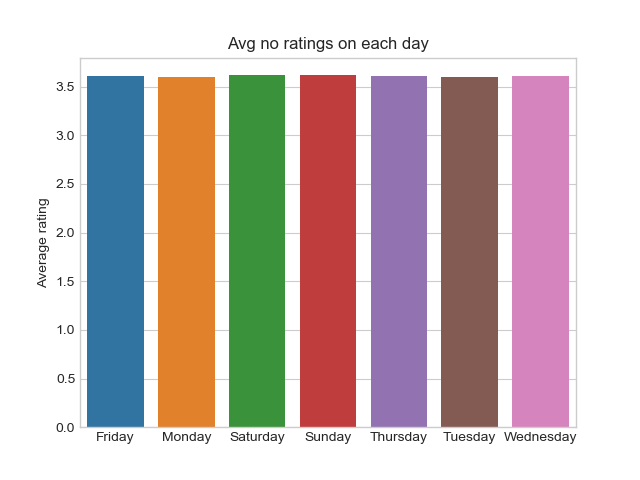

In [32]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
sns.barplot(x=avg_week_df.index, y=avg_week_df.values)
plt.title('Avg no ratings on each day')
plt.ylabel('Average rating')
plt.xlabel('')
plt.show()

# 2. Creating sparse matrix for user-movie-rating from dataframe 

In [33]:
from scipy.sparse import csr_matrix
# csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
# It should be in such a way that, MATRIX[row, col] = data
sparse_matrix = csr_matrix((train_df.rating.tolist(), (train_df.user.tolist(),
                                               train_df.movie.tolist())), 
                           shape=(max(train_df.user)+1,max(train_df.movie)+1))
print('(user, movie) : ',sparse_matrix.shape)

(user, movie) :  (2649430, 17771)


In [34]:
# load or save the sparse matrix from the disk.....
from scipy import sparse

# *****************************************************

# save the sparse matrix to file..
# sparse.save_npz('sparse_matrix.npz', sparse_matrix)

# *****************************************************

# load the sparse matrix from the disk 
sparse_matrix = sparse.load_npz('sparse_matrix.npz')

In [35]:
# u : row indices(userIds) that has an entry(rating to some movie)
# m : column indices(movieIds) that has an entry(rated by some user)
#  One entry from both (x and y) is a non-zero entry....
u,m = sparse_matrix.nonzero()


# ".A1" is for converting Column matrix to 1-D numpy array 
sum_of_ratings_per_user = sparse_matrix.sum(axis=1).A1
# no of ratings that each user has given.
no_ratings_per_user = sparse_matrix.getnnz(axis=1)


# sum of the ratings that a movie got by any user(who rated that movie..)
sum_of_ratings_per_movie = sparse_matrix.sum(axis=0).A1
# no of ratings that a movie got.
no_ratings_per_movie = sparse_matrix.getnnz(axis=0)
# ratings_per_movie = ratings_per_movie[ratings_per_movie!=0]

# calculate AVERAGE Rating w.r.t user and movie.
avg_rating_per_movie = np.divide(sum_of_ratings_per_movie, no_ratings_per_movie, where=no_ratings_per_movie!=0)
avg_rating_per_user  = np.divide(sum_of_ratings_per_user, no_ratings_per_user, where=no_ratings_per_user!=0)
# avg_rating_per_user = avg_rating_per_user[avg_rating_per_user<=5]

# We don't get empty columns(movies), but We have empty rows(users),
# Because all movies are from 1 to 2,649,430. But users are selected at random...
avg_rating_per_user = avg_rating_per_user[avg_rating_per_user!=0]

<IPython.core.display.Javascript object>


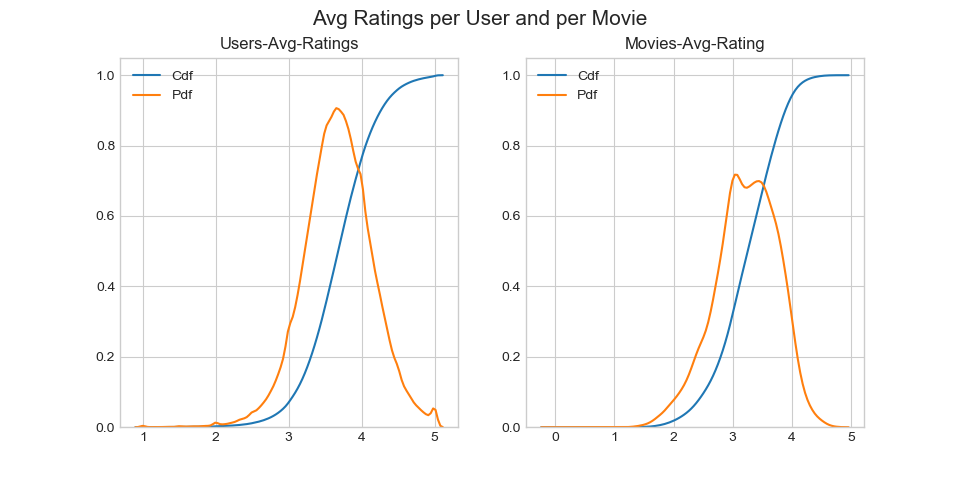

In [36]:
# draw pdfs for average rating per user and average
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

# print('plotting cdf of user')
ax1.set_title('Users-Avg-Ratings')
sns.distplot(avg_rating_per_user, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
# print('plotting pdf of user')
sns.distplot(avg_rating_per_user, ax=ax1, hist=False,label='Pdf')

# print('plotting cdf of movie')
ax2.set_title('Movies-Avg-Rating')
sns.distplot(avg_rating_per_movie, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
# print('plotting pdf of movie')
sns.distplot(avg_rating_per_movie, ax=ax2, hist=False, label='Pdf')

plt.show()

# 3.1 Computing Similarity matrices

In [37]:
from sklearn.metrics.pairwise import cosine_similarity

sparse_matrix.shape

(2649430, 17771)

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

## 3.1.1 Computing User-User Similarity matrix

1. Calculating User User Similarity_Matrix is not possible because of **2.6 M * 2.6 M** dimensions...

    * It is better to calculate them on the fly ( whenever required and store them without the need of re computing them again when its necessary...
    * You can try If you want to. Your system will crash or Program stops with **Memory Error**

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

## 3.1.2 Computing Movie-Movie similarity matrix

In [40]:
from datetime import datetime
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

In [41]:
# Run this if you don't have movie_movie sim matrix..
####################################################
# start = datetime.now()
# m_m_sim = cosine_similarity(X=sparse_matrix.T, dense_output=False)
# print("Movie_Movie :(",datetime.now()-start,")")

# from scipy.sparse import save_npz, load_npz

# # save Movie Movie Similarity Matrix to disk
# save_npz('m_m_sim_sparse.npz', m_m_sim)



In [42]:
# load the Movie-Movie Similarity matrix from disk
m_m_sim_sparse = sparse.load_npz('m_m_sim_sparse.npz')
m_m_sim_sparse.shape

(17771, 17771)